# 

title: Water Rights Restored to the Gila River

subtitle: The impacts of irrigation on vegetation health in the Gila
River Valley

author:

-   Elsa Culler

-   Nate Quarderer

date: last-modified

image: /img/earth-analytics/water-rights/lesson-water-rights.png

image-alt: “Dry river with dead plants turns into a stream with living
plants”

description: \|

In 2004, the Akimel O’‘otham and Tohono O’’odham tribes won a water
rights settlement in the US Supreme Court. Using satellite imagery, we
can see the effects of irrigation water on the local vegetation.

learning-goals:

-   Open raster or image data using code

-   Combine raster data and vector data to crop images to an area of
    interest

-   Summarize raster values with stastics

-   Analyze a time-series of raster images

params:

id: stars

site_name: Gila River Indian Community

event: water rights case

data_dir: gila-river

jupyter:

kernelspec:

    name: learning-portal

    language: python

    display_name: Learning Portal

# STEP 2: Wrangle Raster Data

# STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [1]:
%store -r

You will also need to import any libraries you are using in this
notebook, since they won’t carry over from the previous notebook:

In [3]:
# Import libraries
from glob import glob

import earthpy
import rioxarray as rxr # to work with raster data
import xarray as xr # to work with data arrays

## Load in NDVI data

Now you need to load all the downloaded files into Python. Let’s start
by getting all the file names. You will also need to extract the date
from the filename. Check out [the lesson on getting information from
filenames in the
textbook](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/loops/data-workflows-with-loops/).

In this lesson, you will use the `glob.glob()` function in Python to
find all files that match a **pattern** formed with the **wildcard**
character `*`. The wildcard can represent any string of alphanumberic
characters. For example, the pattern `'file_*.tif'` will match the files
`'file_1.tif'`, `'file_2.tiv'`, or even
`'file_qeoiurghtfoqaegbn34pf.tif'`… but it will not match
`'something-else.csv'` or even `'something-else.tif'`.

In this notebook, we’ll use the `.rglob()`, or **recursive** glob method
of the Path object instead. It works similarly, but you’ll notice that
we have to convert the results to a list with the `list()` function.

> **GOTCHA ALERT!**
>
> `glob` doesn’t necessarily find files in the order you would expect.
> Make sure to **sort** your file names like it says in the textbook.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Take a look at the file names for the NDVI files. What do you notice
is the same for all the files? Keep in mind that you only want the NDVI
files, not the Quality files (which will flag potential incorrect
measurements).</p></div></div>

YOUR ANSWER HERE

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Create a <strong>pattern</strong> for the files you want to import.
Your pattern should include the parts of the file names that are the
same for all files, and replace the rest with the <code>*</code>
character. Make sure to match the NDVI files, but not the Quality
files!</li>
<li>Replace <code>ndvi-pattern</code> with your pattern</li>
<li>Run the code and make sure that you are getting all the files you
want and none of the files you don’t!</li>
</ol></div></div>

In [4]:
# Get a sorted list of NDVI tif file paths
ndvi_paths = sorted(list(project.project_dir.rglob('*NDVI*.tif')))

# Display the first and last three files paths to check the pattern
ndvi_paths[:3], ndvi_paths[-3:]

([PosixPath('/workspaces/data/my-data-folder/gila-river-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001145000000_aid0001.tif'),
  PosixPath('/workspaces/data/my-data-folder/gila-river-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001161000000_aid0001.tif'),
  PosixPath('/workspaces/data/my-data-folder/gila-river-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001177000000_aid0001.tif')],
 [PosixPath('/workspaces/data/my-data-folder/gila-river-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2022209000000_aid0001.tif'),
  PosixPath('/workspaces/data/my-data-folder/gila-river-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2022225000000_aid0001.tif'),
  PosixPath('/workspaces/data/my-data-folder/gila-river-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2022241000000_aid0001.tif')])

## Repeating tasks in Python

Now you should have a few dozen files! For each file, you need to:

-   Load the file in using the `rioxarray` library
-   Get the date from the file name
-   Add the date as a dimension coordinate
-   Give your data variable a name

You don’t want to write out the code for each file! That’s a recipe for
copy pasta. Luckily, Python has tools for doing similar tasks
repeatedly. In this case, you’ll use one called a `for` loop.

There’s some code below that uses a `for` loop in what is called an
**accumulation pattern** to process each file. That means that you will
save the results of your processing to a list each time you process the
files, and then merge all the arrays in the list.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ul>
<li>Look at the file names. How many characters from the end is the
date? <code>doy_start</code> and <code>doy_end</code> are used to
extract the day of the year (doy) from the file name. You will need to
count characters from the end and change the values to get the right
part of the file name. HINT: the index -1 in Python means the last
value, -2 second-to-last, and so on.</li>
<li>Replace any required variable names with your chosen variable
names</li>
</ul></div></div>

In [15]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

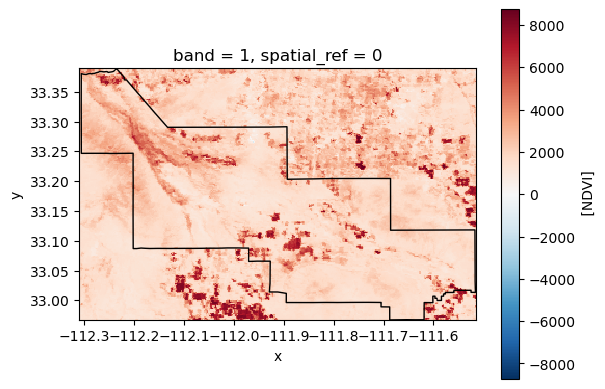

In [18]:
# plot first and last .tif image
rxr.open_rasterio(ndvi_paths[-1], mask_adan_scale=True).squeeze().plot()

gric_boundary.plot(ax=plt.gca(), edgecolor= 'black', color='none')

In [5]:
doy_start = -1
doy_end = -1

# Loop through each NDVI image
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name

    # Open dataset

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Prepare for concatenation

## Combine Rasters

Next, stack your arrays by date into a time series using the
`xr.combine_by_coords()` function. You will have to tell it which
dimension you want to stack your data in.

In [7]:
# Combine NDVI images from all dates

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [9]:
%store var1 var2

Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!